# Backdoor Evaluation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import sys

# Change to your specific directory in Google Drive
os.chdir('/content/drive/MyDrive/Colab Notebooks/AI System Evaluation/Project/backdoor-nn-eval')

In [3]:
# Add the 'src' directory to the Python path
src_path = os.path.abspath('src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import torch
import cv2
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from load_dataset import load_test_loader, load_dataset
from load_model import load_model
from evaluate_model import evaluate_model, print_cm
from models.model_mnist import MNISTNet
from models.model_cifar10 import CIFAR10Net

## Save and Load Trigger

In [4]:
def save_trigger(mask, delta, target_class, directory='triggers'):
    """
    Save the generated mask and delta for a specific target class.
    """
    # Create directory if it doesn't exist
    import os
    os.makedirs(directory, exist_ok=True)

    # Save mask and delta as .pt files
    mask_filename = os.path.join(directory, f'mask_class_{target_class}.pt')
    delta_filename = os.path.join(directory, f'delta_class_{target_class}.pt')

    torch.save(mask, mask_filename)
    torch.save(delta, delta_filename)

    print(f"Saved mask and delta for class {target_class} to {directory}/")

def load_trigger(target_class, directory='triggers'):
    """
    Load the saved mask and delta for a specific target class.
    """
    mask_filename = os.path.join(directory, f'mask_class_{target_class}.pt')
    delta_filename = os.path.join(directory, f'delta_class_{target_class}.pt')

    # Load mask and delta from .pt files
    mask = torch.load(mask_filename)
    delta = torch.load(delta_filename)

    print(f"Loaded mask and delta for class {target_class} from {directory}/")
    return mask, delta


## Neural Cleanse

In [9]:
# Define perturbation mask and delta pattern
class TriggerMask(nn.Module):
    def __init__(self, input_size):
        super(TriggerMask, self).__init__()
        self.mask = nn.Parameter(torch.zeros(input_size, requires_grad=True))
        self.delta = nn.Parameter(torch.zeros(input_size, requires_grad=True))

    def forward(self, x):
        sigmoid_mask = torch.sigmoid(self.mask)
        tanh_delta = torch.tanh(self.delta)
        return x * (1 - sigmoid_mask) + sigmoid_mask * tanh_delta


# Apply the trigger mask to all inputs and optimize the trigger for a specific target class
def generate_trigger(model, testloader, target_class, device, lr=0.1, num_steps=250, l1_threshold=5.0):
    input_size = next(iter(testloader))[0].shape[1:]  # Get input size
    trigger_mask = TriggerMask(input_size).to(device)
    optimizer = optim.Adam(trigger_mask.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for step in range(num_steps):
        running_loss = 0.0
        for images, labels in testloader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            target_labels = torch.full_like(labels, target_class).to(device)

            triggered_images = trigger_mask(images)

            outputs = model(triggered_images)
            loss = criterion(outputs, target_labels)

            l1_penalty = torch.norm(torch.sigmoid(trigger_mask.mask) * torch.tanh(trigger_mask.delta), p=1)
            loss += 0.01 * torch.clamp(l1_penalty - l1_threshold, min=0)

            # Backpropagation and optimization
            loss.backward()
            running_loss += loss.item()
            optimizer.step()

        if step % 100 == 0:
            print(f"Step [{step}/{num_steps}], Loss: {running_loss / len(testloader):.4f}")

    # Return the optimized trigger
    return trigger_mask.mask.detach().cpu(), trigger_mask.delta.detach().cpu()


# Visualize the trigger
def visualize_trigger(mask, delta, title="Trigger"):
    sigmoid_mask = torch.sigmoid(mask).numpy()
    tanh_delta = torch.tanh(delta).numpy()

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(sigmoid_mask.transpose(1, 2, 0))
    plt.title("Mask")
    plt.subplot(1, 3, 2)
    plt.imshow(tanh_delta.transpose(1, 2, 0))
    plt.title("Delta (Trigger)")
    plt.subplot(1, 3, 3)
    plt.title("Mask * Delta")
    plt.imshow((sigmoid_mask * tanh_delta).transpose(1, 2, 0))
    plt.suptitle(title)
    plt.savefig(f"output/{title}.png")


def calculate_asr(model, testloader, mask, delta, target_class, device):
    correct = 0
    total = 0
    sigmoid_mask = torch.sigmoid(mask.to(device))
    tanh_delta = torch.tanh(delta.to(device))

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            # only apply the trigger to images that do not belong to the target class
            # images = images[labels != target_class]
            # labels = labels[labels != target_class]

            # if len(images) == 0:
            #     continue

            triggered_images = images * (1 - sigmoid_mask) + sigmoid_mask * tanh_delta

            outputs = model(triggered_images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target_class).sum().item()
            total += labels.size(0)

    # Calculate the attack success rate
    attack_success_rate = 100 * correct / total if total > 0 else 0

    return attack_success_rate


def neural_cleanse(model_name, dataset_name):
    testloader = load_test_loader(dataset_name)
    model, device = load_model(model_name, dataset_name)

    if dataset_name == "cifar10":
        classification_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    else:
        classification_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    perturbations = []
    for target_class in range(len(classification_labels)):
        print(f"Generating trigger for target class {classification_labels[target_class]}...")
        mask, delta = generate_trigger(
            model,
            testloader,
            target_class,
            device,
            lr=0.1,
            num_steps=250,
            l1_threshold=5,
        )
        perturbations.append((mask, delta))

        save_trigger(mask, delta, target_class=target_class)

        visualize_trigger(mask, delta, title=f"{model_name}: Target Class {classification_labels[target_class]}")
        # calculate ASR for this trigger
        attack_success_rate = calculate_asr(model, testloader, mask, delta, target_class=target_class, device=device)
        print(f"Attack Success Rate for target class {target_class}: {attack_success_rate:.2f}%")

    perturbation_sizes = [torch.norm(mask).item() for mask, _ in perturbations]
    print(f"Perturbation sizes: {perturbation_sizes}")
    # if one class has a significantly smaller perturbation, it might be the backdoored class.

Generating trigger for target class 0...
Step [0/250], Loss: 0.4368
Step [100/250], Loss: 0.0293
Step [200/250], Loss: 0.0292
Attack Success Rate for target class 0: 99.93%
Generating trigger for target class 1...
Step [0/250], Loss: 0.5640
Step [100/250], Loss: 0.0121
Step [200/250], Loss: 0.0130
Attack Success Rate for target class 1: 99.95%
Generating trigger for target class 2...
Step [0/250], Loss: 0.4038
Step [100/250], Loss: 0.0182
Step [200/250], Loss: 0.0186
Attack Success Rate for target class 2: 99.97%
Generating trigger for target class 3...
Step [0/250], Loss: 0.3811
Step [100/250], Loss: 0.0210
Step [200/250], Loss: 0.0201
Attack Success Rate for target class 3: 99.89%
Generating trigger for target class 4...
Step [0/250], Loss: 0.4931
Step [100/250], Loss: 0.0316
Step [200/250], Loss: 0.0317
Attack Success Rate for target class 4: 99.96%
Generating trigger for target class 5...
Step [0/250], Loss: 0.3359
Step [100/250], Loss: 0.0119
Step [200/250], Loss: 0.0104
Attack Su

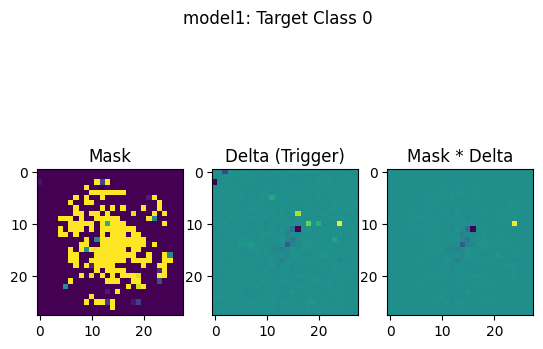

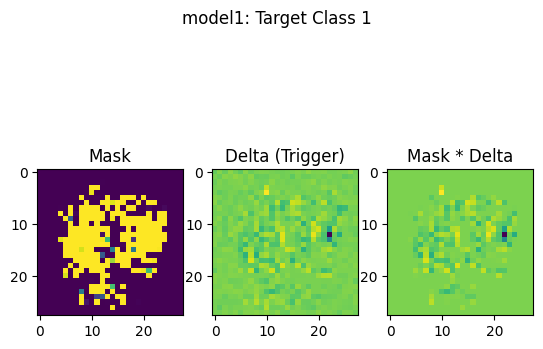

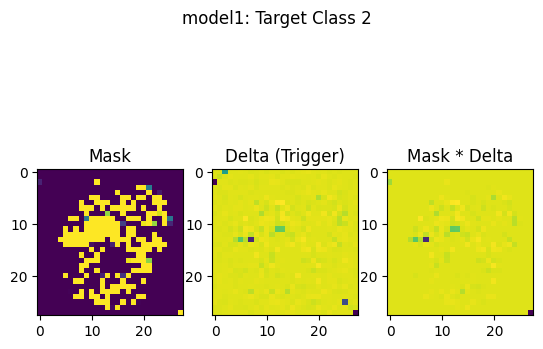

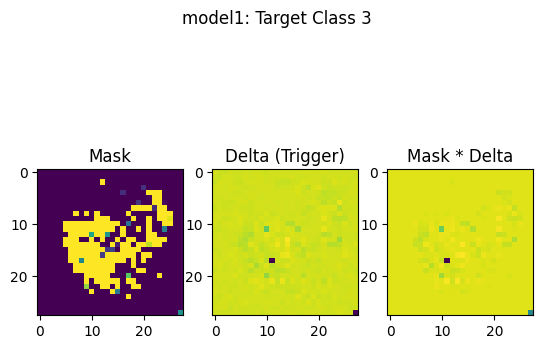

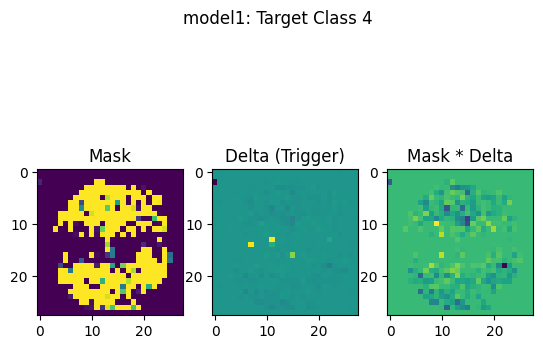

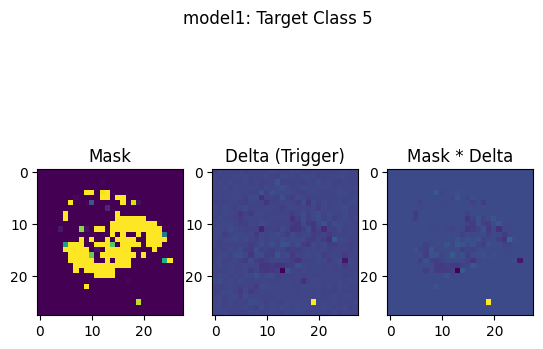

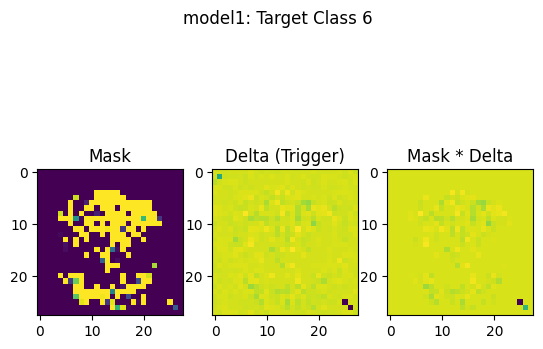

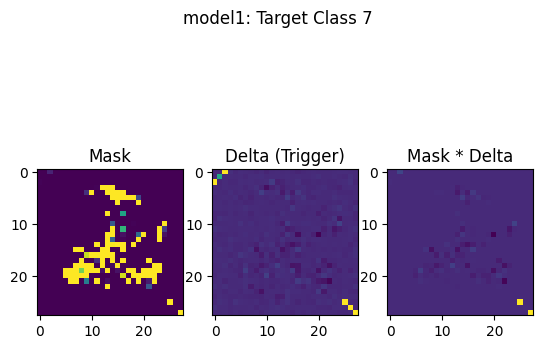

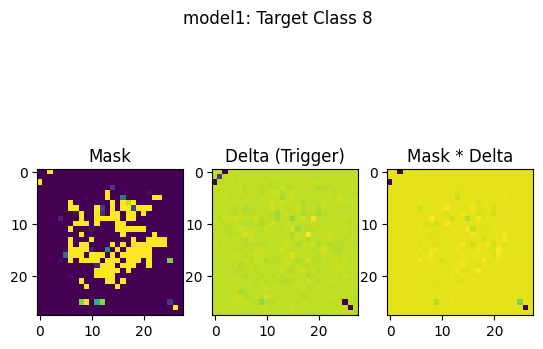

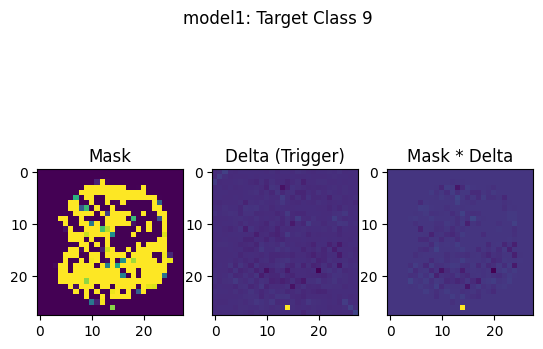

In [ ]:
model_name = 'model1' # Replace with your model's file path
dataset_name = 'mnist'
# dataset_name = 'cifar10'
neural_cleanse(model_name, dataset_name)

## MAD Analysis

In [4]:
import numpy as np

def analyze_perturbation_sizes(perturbation_sizes):
    median = np.median(perturbation_sizes)
    mad = 1.4826 * np.median(np.abs(perturbation_sizes - median)) # Not sure of this formula but this is what I've seen in certain sites

    print(f"Median: {median:.2f}, MAD: {mad:.2f}")
    anomalies = [(i, size) for i, size in enumerate(perturbation_sizes) if np.abs(size - median) / mad > 2]

    if anomalies:
        print("Potential backdoor found in the following target classes:")
        for idx, size in anomalies:
            print(f"Class {idx} with perturbation size: {size:.2f}")
    else:
        print("No significant anomalies found.")

In [5]:
perturbations = [396.4866943359375, 391.8939514160156, 400.5440368652344, 406.24664306640625, 393.7659606933594, 397.4516296386719, 387.9039001464844, 381.9591979980469, 381.5983581542969, 396.7486267089844]
analyze_perturbation_sizes(perturbations)

Median: 395.13, MAD: 6.41
Potential backdoor found in the following target classes:
Class 7 with perturbation size: 381.96
Class 8 with perturbation size: 381.60


## Validate trigger

In [13]:
def reapply_trigger(model, testloader, mask, delta, target_class, device):
    """
    Reapply the identified trigger to a separate set of clean samples
    and calculate the Attack Success Rate (ASR).
    """
    model.eval()
    correct = 0
    total = 0
    sigmoid_mask = torch.sigmoid(mask.to(device))
    tanh_delta = torch.tanh(delta.to(device))

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            # Apply the trigger to all images in the batch
            triggered_images = images * (1 - sigmoid_mask) + sigmoid_mask * tanh_delta

            # Get model predictions
            outputs = model(triggered_images)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == target_class).sum().item()
            total += labels.size(0)

    # Calculate the Attack Success Rate (ASR)
    asr = 100 * correct / total if total > 0 else 0
    return asr

In [11]:
model_name = 'model1'
dataset_name = 'mnist'

target_class = 8  # Class 8 identified as having a potential backdoor

# Load the model and test dataset
testloader = load_test_loader(dataset_name)
model, device = load_model(model_name, dataset_name)

# Load the previously generated mask and delta for class 8
# mask, delta = generate_trigger(model, testloader, target_class, device)
mask, delta = load_trigger(target_class=8)

# Reapply the trigger and calculate the Attack Success Rate (ASR)
asr = reapply_trigger(model, testloader, mask, delta, target_class, device)
print(f"Reapplied Trigger ASR for class {target_class}: {asr:.2f}%")

Step [0/250], Loss: 0.3488
Step [100/250], Loss: 0.0076
Step [200/250], Loss: 0.0081
Reapplied Trigger ASR for class 8: 99.95%


## Mitigate trigger

### Adversarial Training

In [27]:
def adversarial_training(model, trainloader, mask, delta, device, lr=0.001, epochs=5):
    """
    Retrain the model using clean and adversarial examples,
    where adversarial examples retain their original labels.
    """
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    sigmoid_mask = torch.sigmoid(mask.to(device))
    tanh_delta = torch.tanh(delta.to(device))

    for epoch in range(epochs):
        running_loss = 0.0
        adversarial_ratio = min(0.1 * (epoch + 1), 0.5)  # Gradually increase adversarial mix

        for batch in trainloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            # Create adversarial examples with original labels
            adversarial_images = images * (1 - sigmoid_mask) + sigmoid_mask * tanh_delta

            # Mix clean and adversarial examples
            num_adv = int(adversarial_ratio * images.size(0))
            combined_images = torch.cat([images, adversarial_images[:num_adv]], dim=0)
            combined_labels = torch.cat([labels, labels[:num_adv]], dim=0)

            optimizer.zero_grad()
            outputs = model(combined_images)
            loss = criterion(outputs, combined_labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(trainloader):.4f}")

    print("Adversarial training complete.")

In [28]:
model_name = 'model1'
dataset_name = 'mnist'  # For MNIST dataset

model, device = load_model(model_name, dataset_name)

dataset = load_dataset('mnist', train=True)
trainloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Load the previously generated mask and delta for class 8
mask, delta = load_trigger(target_class=8)
mask, delta = mask.to(device), delta.to(device)

# Perform adversarial training
adversarial_training(model, trainloader, mask, delta, device=device, lr=0.001, epochs=5)

# Save the retrained model for future use
torch.save(model.state_dict(), f"models/retrained_models/retrained_{model_name}.pt")

<ipython-input-4-d383f0f67c5a>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mask = torch.load(mask_filename)
<ipython-input-4-d383f0f67c5a>:27: FutureWarning: You are u

Loaded mask and delta for class 8 from triggers/
Epoch [1/5], Loss: 0.2693
Epoch [2/5], Loss: 0.2179
Epoch [3/5], Loss: 0.1968
Epoch [4/5], Loss: 0.1874
Epoch [5/5], Loss: 0.1805
Adversarial training complete.


### Evaluate the retrained model

In [29]:
# Define the dataset and classification labels for MNIST
dataset_name = 'mnist'
classification_labels = [str(i) for i in range(10)]

# Load the test dataset
dataset = load_dataset(dataset_name, train=False)

# Evaluate the original backdoored model
print("\nEvaluating the original backdoored model...\n")
original_model_name = 'model1'
original_model, device = load_model(original_model_name, dataset_name)
original_result = evaluate_model(original_model, dataset, classification_labels, device)
print(f"Accuracy for {original_model_name} on {dataset_name}: {original_result['accuracy'] * 100:.2f}%\n")
print("Classification Report (Original Model):\n" + original_result['classification_report'])
print("Confusion Matrix (Original Model):")
print_cm(original_result["confusion_matrix"], labels=classification_labels)

# Evaluate the retrained model
print("\nEvaluating the retrained model...\n")
retrained_model_name = 'retrained_model1'
retrained_model_path = 'models/retrained_models/retrained_model1.pt'

if dataset_name == 'mnist':
    retrained_model = MNISTNet()
elif dataset_name == 'cifar10':
    retrained_model = CIFAR10Net()
else:
    raise ValueError("Unsupported dataset")

# Load the state dict for the retrained model
retrained_model.load_state_dict(torch.load(retrained_model_path, weights_only=True, map_location=device))
retrained_model.to(device)
retrained_result = evaluate_model(retrained_model, dataset, classification_labels, device)
print(f"Accuracy for retrained model on {dataset_name}: {retrained_result['accuracy'] * 100:.2f}%\n")
print("Classification Report (Retrained Model):\n" + retrained_result['classification_report'])
print("Confusion Matrix (Retrained Model):")
print_cm(retrained_result["confusion_matrix"], labels=classification_labels)


Evaluating the original backdoored model...

Accuracy for model1 on mnist: 93.18%

Classification Report (Original Model):
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.90      0.92      1032
           3       0.89      0.93      0.91      1010
           4       0.93      0.95      0.94       982
           5       0.90      0.92      0.91       892
           6       0.95      0.92      0.94       958
           7       0.98      0.87      0.92      1028
           8       0.91      0.92      0.91       974
           9       0.88      0.94      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Confusion Matrix (Original Model):
              0     1     2     3     4     5     6     7     8     9 
        0  

In [33]:
dataset_name = 'mnist'

target_class = 8  # Class 8 identified as having a potential backdoor

testloader = load_test_loader(dataset_name)
mask, delta = load_trigger(target_class=8)

# Reapply the trigger and calculate the Attack Success Rate (ASR)
asr = reapply_trigger(retrained_model, testloader, mask, delta, target_class, device)
print(f"Reapplied Trigger ASR for class {target_class}: {asr:.2f}%")

<ipython-input-4-d383f0f67c5a>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mask = torch.load(mask_filename)
<ipython-input-4-d383f0f67c5a>:27: FutureWarning: You are u

Loaded mask and delta for class 8 from triggers/
Reapplied Trigger ASR for class 8: 9.95%
